In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import hist
from hist import Hist
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, schemas
import numpy as np

In [2]:
fileset = "/eos/home-b/bchitrod/HHH/NANOAOD/TRSM_XToHY_6b_M3_2000_M2_1100_NANOAOD.root" 

In [3]:
eventsToRead = 10000
events = NanoEventsFactory.from_root(fileset,schemaclass=NanoAODSchema,metadata={"dataset": "testSignal"},entry_stop=eventsToRead).events()

In [5]:
fatjets = events.FatJet
jets = events.Jet

##FatJet cuts
ptcut = 250
etacut = 2.5
mass_cut = [110,140]
pNet_cut = 0.9105

good_fatjets = fatjets[(fatjets.pt>ptcut) & (np.absolute(fatjets.eta)<etacut) & (fatjets.msoftdrop>=mass_cut[0]) & (fatjets.msoftdrop<=mass_cut[1])] #& (fatjets.particleNet_HbbvsQCD>=pNet_cut)
good_semiboosted = good_fatjets[ak.num(good_fatjets, axis=1) == 2]
good_boosted = good_fatjets[ak.num(good_fatjets, axis=1)> 2]

## Resolved Jet cuts
res_ptcut = 30
res_etacut = 2.5
res_mass_cut = [90,140]
# loose cut = 0.0532, med_cut = 0.3040, tight_cut = 0.7476 , https://twiki.cern.ch/twiki/bin/view/CMS/BtagRecommendation106XUL17
res_deepBcut = 0.0532

good_jets = jets[(jets.pt > res_ptcut) & (np.absolute(jets.eta) < res_etacut)] #& (jets.btagDeepB>res_deepBcut)

res_jets = (good_jets[ak.num(good_fatjets, axis=1) == 2])
good_pairs = res_jets.nearest(good_semiboosted).delta_r(res_jets)>0.8
good_paired = res_jets[good_pairs]
res_bjets = (good_paired[ak.num(good_paired, axis=1) >= 2])

mass = (res_bjets[:,0]+res_bjets[:,1]).mass
selected_jets = res_bjets[((res_bjets[:,0]+res_bjets[:,1]).mass>=res_mass_cut[0]) &  ((res_bjets[:,0]+res_bjets[:,1]).mass<=res_mass_cut[1])]
selected_fatjets = good_semiboosted[ak.num(selected_jets, axis=1)>1]

In [6]:
trijet_mass = (selected_fatjets[:,0]+selected_fatjets[:,1]+selected_jets[:,0]+selected_jets[:,1]).mass

In [7]:
dijet1_mass = (selected_fatjets[:,0]+selected_fatjets[:,1]).mass
dijet2_mass = (selected_fatjets[:,0]+selected_jets[:,0]+selected_jets[:,1]).mass
dijet3_mass = (selected_fatjets[:,1]+selected_jets[:,0]+selected_jets[:,1]).mass

In [8]:
j3_bin = hist.axis.Regular(label="Trijet Mass [GeV]", name="trijet_mass", bins=40, start=0, stop=4000)
j3_cat = hist.axis.StrCategory(label='Trijets', name='trijet', categories=["signal"])

In [9]:
j3_hist = Hist(j3_bin, j3_cat)
j3_hist.fill(trijet="signal", trijet_mass=trijet_mass)

Hist(
  Regular(40, 0, 4000, name='trijet_mass', label='Trijet Mass [GeV]'),
  StrCategory(['signal'], name='trijet', label='Trijets'),
  storage=Double()) # Sum: 531.0 (532.0 with flow)

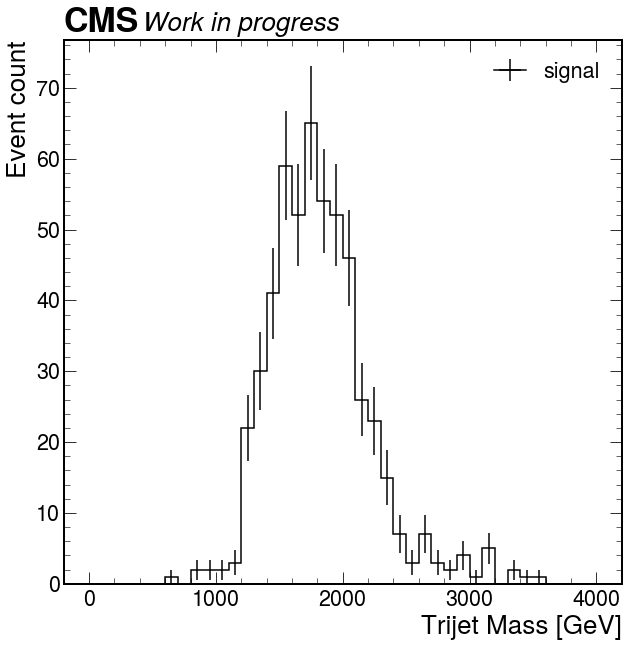

In [10]:
import mplhep as hep
plt.style.use([hep.style.CMS])
j3_hist.plot(color="black")
hep.cms.text("Work in progress",loc=0)
plt.ylabel("Event count",horizontalalignment='right', y=1.0)
plt.legend()

In [11]:
j2_bin = hist.axis.Regular(label="Dijet Mass [GeV]", name="dijet_mass", bins=40, start=0, stop=2000)
j2_cat = hist.axis.StrCategory(label='Dijets', name='dijet', categories=["Pair1","Pair2","Pair3"])

In [12]:
j2_hist = Hist(j2_bin, j2_cat)
j2_hist.fill(dijet="Pair1", dijet_mass=dijet1_mass)
j2_hist.fill(dijet="Pair2", dijet_mass=dijet2_mass)
j2_hist.fill(dijet="Pair3", dijet_mass=dijet3_mass)

Hist(
  Regular(40, 0, 2000, name='dijet_mass', label='Dijet Mass [GeV]'),
  StrCategory(['Pair1', 'Pair2', 'Pair3'], name='dijet', label='Dijets'),
  storage=Double()) # Sum: 1572.0 (1596.0 with flow)

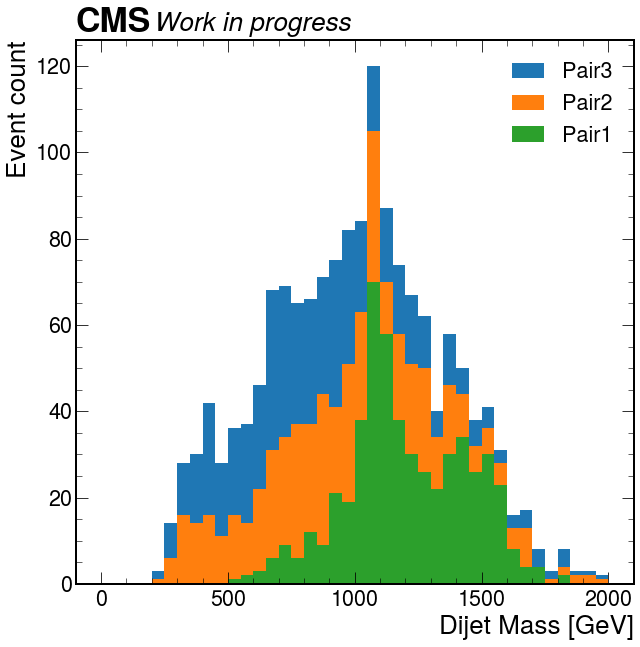

In [13]:
j2_hist.plot(stack=True,histtype='fill')
hep.cms.text("Work in progress",loc=0)
plt.ylabel("Event count",horizontalalignment='right', y=1.0)
plt.legend()